# Classify continental shelf into different Antarctic Slope Front regimes

This script:

1. Goes through every nth longitude and 1 degree north/south from the latitude that intersects the longitude on the 1 km isobath to select a transect.
2. Plots for each transect 
    - a map of the continental shelf and Southern Ocean together with the location of the current transect
    - the transect (temperature and sigma_1 contours)
    - 10 year mean
3. Per hand, each transect is classified into a different regime (see regime definitions below).
4. Saves the transects and an array with the ASF classification.

---
ASF regime definition (after Moorman et al., 2020):  
**Fresh**:   
- $\sigma_1$ contours containing open ocean warm water ($\theta>0^{\circ}$C) intersect with continental slope
- no warm waters are found polewards of the shelf break

**Dense**:  
- isopycnal connection exists between cold ($\theta<0^{\circ}$C) shelf waters and open ocean below 1500 m

**Warm**:  
- warm water is found on shelf
- execpt: where dense classification is satisfied

**Cool**: (might skip this one)  
- no warm water is found on shelf...
- despite the absence of a frontal barrier...
- or DSW overflows at the shelf break
---

Load modules:

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
from cosima_cookbook import distributed as ccd

# Optional modules
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import matplotlib.gridspec as gridspec
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
import gsw

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client(n_workers=8) # n_workers=4
client

<Client: 'tcp://127.0.0.1:44717' processes=8 threads=8, memory=34.36 GB>

Nominate a database from which to load the data and define an experiment:

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load isobath information

These are previously calculated (`find_depth_contour_smoothed.ipynb` and `Calc_isobath_contour_infos.ipynb`)

In [4]:
isobath_depth = 1000

In [178]:
# Load the isobath information
#contour_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm.npz'
contour_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_1km_velocities_plt_approach.npz'
data = np.load(contour_path)

In [180]:
# We are interested in the t-grid:
#num_points = data['num_points_t']
#distance_along_contour = data['distance_along_contour_t']
#lon_along_contour = data['lon_along_contour_t']
#lat_along_contour = data['lat_along_contour_t']

num_points = data['num_points']
distance_along_contour = data['distance_along_contour']
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']

### Load in transect information (from [Ruth Moorman's work](https://github.com/ruth-moorman/positive-and-negative-feedbacks-to-Antarctic-ice-shelf-melt-FIGURES/blob/master/Fig_4_asf_categorisation.ipynb))

In [7]:
transect_lons = [75,75,70,70,65,65,60,60,55,55,51,51,45,45,40,40,35,35,30,30,25,25,15,15,10,10,5,5,-5,-5,-10,-10,-15,-15,-22.5,-22.5,-30,-30,-35,-35,-40,-40,-45,-45,-50,-50,-85,-85,-90,-90,-95,-95,-100,-100,-105,-105,-110,-110,-115,-115,-120,-120,-125,-125,-130,-130,-135,-135,-140,-140,-145,-145,-150,-150,-155,-155,-160,-160,-165,-165, -170,-170,-175,-175,-180,-180,-185,-185,-190,-190,-195,-195,-200,-200,-205,-205,-210,-210,-215,-215,-220,-220,-225,-225,-230,-230,-235,-235,-240,-240,-245,-245,-250,-250,-255,-255,-260,-260,-265,-265,-270,-270,-275,-275,-279.8,-279.8,-54,-48,-58,-52,-58,-52]
transect_lats = [-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-66,-64,-66.5,-64.55,-68,-66,-69,-67,-69,-67,-69.5,-67.5,-70.5,-68.5,-70,-68,-70.5,-68.5,-70.5,-68.5,-71,-69,-71.5,-69.5,-72.5,-70.5,-74.5,-72.5,-75,-73,-75,-73,-74.5,-72.5,-73.5,-71.5,-73,-71,-73.5,-69,-73,-69.5, -72.5,-69.5,-72,-69.5,-75,-70,-74.5,-70,-74,-70.5,-74,-71,-74,-71,-74.5,-72,-75,-72.5,-75.5,-73,-75.5,-73.5,-77,-74.5,-77.5,-75,-78.2,-75,-78.7,-75,-78.5,-75,-78.5,-74, -74.5,-71.5,-74,-71,-71.7,-69.5,-70.8,-68.5,-70.5,-68,-69,-65.5,-68.5,-64.5,-67.3,-64.5,-66.8,-64.5,-66.5,-63.5,-66.5,-63.5,-67,-64,-67,-64,-66.7,-64,-67,-64,-66.5,-63.5,-66,-62.8,-66.5,-63.5,-67,-64.5,-66.8,-64.5,-68,-64.5,-63.5,-63.5,-67,-67,-70,-70]

WAP_names = ['wap_1', 'wap_6', 'wap_7', 'wap_2', 'wap_3', 'wap_4', 'wap_5', 'wap_8']
WAP_lons = [-80,-82,-61.25,-65.75,-56.5,-59,-79,-74,-77,-71,-74,-68.5,-70,-65,-55,-48]
WAP_lats = [-70,-68,-63.25,-61, -62,-60,-67.5,-69,-66.25,-67.75,-65,-66.5,-63,-64.5,-62.5,-62.75];

### Map with transects

In [8]:
lat_slice = slice(-80, -59)

start_time = '2080-01-01'
end_time   = '2089-12-31' 

# Import bathymetry 
# Note: I load in the t-grid, but ultimately, I want to add the ASF classification to the ASC plots on the u-grid.
# The output of this script might be slightly offset compared to the u-grid. But that is okay. (The spacing between the transects is much larger 
# than the spacing of the u-point and t-point on the grid cell.)
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()

In [9]:
ft_size = 18
fig_path = '/g/data/x77/wgh581/Figures/'

In [10]:
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

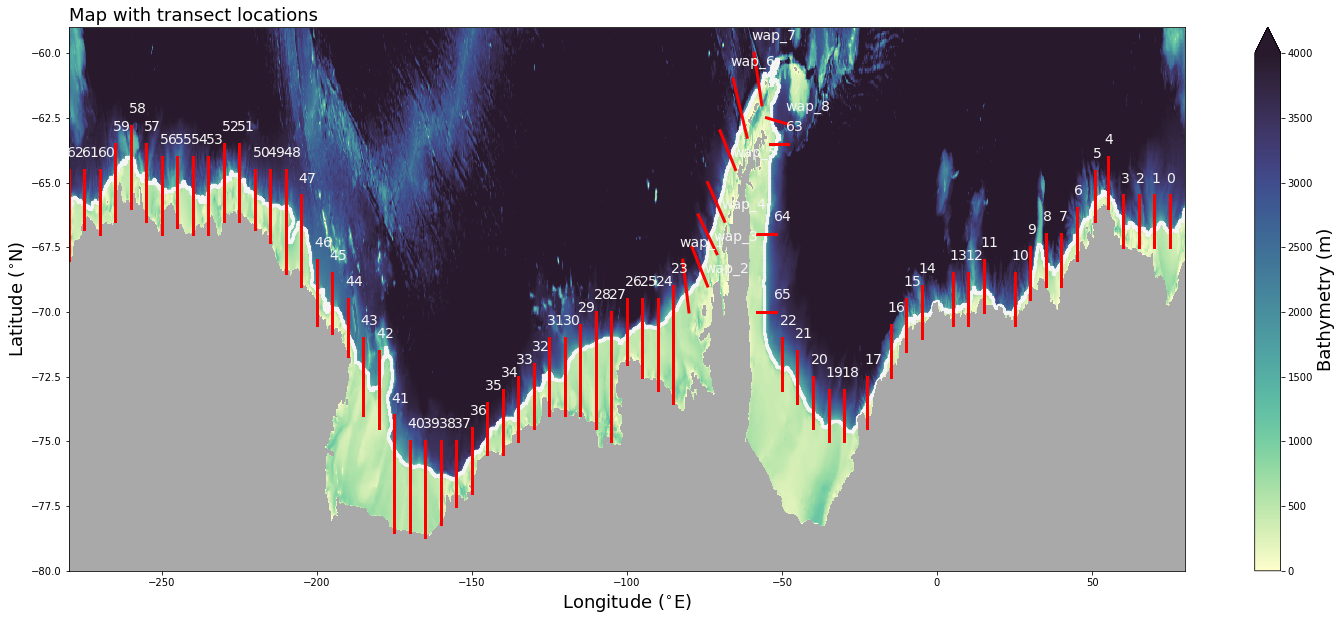

In [11]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1,1,1)
plt.title('Map with transect locations', fontsize=ft_size, loc='left')
plt.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
sc = plt.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, cmap=cm.cm.deep, vmin=0, vmax=4000)
plt.scatter(lon_along_contour, lat_along_contour, c='whitesmoke', s=5)
#plt.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[1000], colors='k')
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -59)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
cbar = plt.colorbar(sc, extend='max')
cbar.set_label('Bathymetry (m)', fontsize=ft_size)
# Add transects
for ii in range(int(len(transect_lons)/2)):
    plt.plot(transect_lons[2*ii:2*ii+2], transect_lats[2*ii:2*ii+2], color='red', linewidth=3)
    plt.text(transect_lons[2*ii+1]-1, transect_lats[2*ii+1]+0.5, '$\mathsf{'+str(ii)+'}$', fontsize=ft_size-4, color='whitesmoke')
for ii in range(len(WAP_names)):
    plt.plot(WAP_lons[2*ii:2*ii+2], WAP_lats[2*ii:2*ii+2], color='red', linewidth=3)
    plt.text(WAP_lons[2*ii+1]-1, WAP_lats[2*ii+1]+0.5, WAP_names[ii], fontsize=ft_size-4, color='whitesmoke')
plt.subplots_adjust(hspace=0.3);

---
### Calculate transects
The code below calculates the transects and saves them, once you did this once, you can skip the following sections and go straight to the plotting section.

In [11]:
file_path = '/g/data/x77/wgh581/Post_Process/Transects_ASF_classification/'

### **Annual average**

Import data

In [12]:
# Conservative temperature, convert to degree Celcius
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc") - 273.15
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean('time')

# Practical salinity, convert later to absolute salinity
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean('time')

Calculate $\sigma_1$

In [13]:
# Move longitude from ACCESS default to -180 - 180 (gsw library assumes either this or 0 - 360 format)
salt['xt_ocean'] = salt['xt_ocean'] + 100
temp['xt_ocean'] = temp['xt_ocean'] + 100

In [14]:
pressure      = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)

In [15]:
salt_absolute = gsw.SA_from_SP(salt, pressure, salt.xt_ocean, salt.yt_ocean) # (move to lon range from -180 to 180)
sigma1        = gsw.sigma1(salt_absolute, temp)

Bottom density

In [109]:
# Array with max depth info (u grid)
depth_array = sigma1 * 0 + sigma1.st_ocean
max_depth_u = depth_array.max(dim='st_ocean', skipna=True)
sigma1_btm  = sigma1.where(depth_array.st_ocean >= max_depth_u)
sigma1_btm  = sigma1_btm.sum(dim='st_ocean')

In [18]:
%%time
simga1_btm = sigma1_btm.load()

Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/asyncio/tasks.py", line 435, in wait_for
    await waiter
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/comm/core.py", line 304, in _
    raise CommClosedError() from e
distributed.comm.core.CommClosedError
Task exception was never retrieved
fut

CPU times: user 1min 59s, sys: 10.1 s, total: 2min 9s
Wall time: 2min 49s


In [ ]:
sigma1_btm['xt_ocean'] = sigma1_btm['xt_ocean'] - 100

In [40]:
import copy
cmap1 = copy.copy(cm.cm.dense)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x149b9c803350>>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/utils_perf.py", line 183, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x149b9c803350>>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/utils_perf.py", line 193, in _gc_callback
    self._fractional_timer.start_timing()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/utils_perf.py", line 116, in start_timing
    assert self._cur_start is None
AssertionError: 


KeyboardInterrupt: 

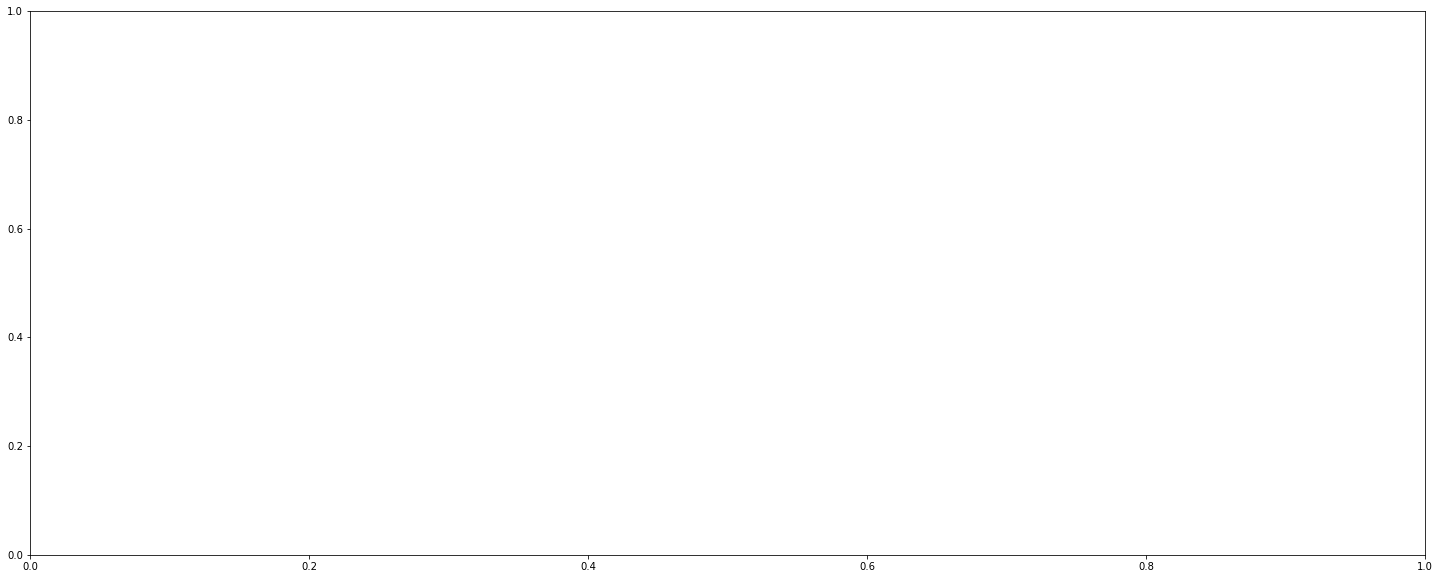

In [112]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1,1,1)
sc = plt.pcolormesh(sigma1_btm.xt_ocean, sigma1_btm.yt_ocean, sigma1_btm.values, vmin=32.4, vmax=32.6, cmap=cmap1)
sc.cmap.set_over('tomato')
cbar = plt.colorbar(sc, extend='both')
cbar.set_label('$\sigma_1$ (kg m$^{-3}$)', fontsize=ft_size)
plt.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.scatter(lon_along_contour, lat_along_contour, c='whitesmoke', s=2)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -59)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
# Add transects
for ii in range(int(len(transect_lons)/2)):
    plt.plot(transect_lons[2*ii:2*ii+2], transect_lats[2*ii:2*ii+2], color='red', linewidth=3)
    plt.text(transect_lons[2*ii+1]-1, transect_lats[2*ii+1]+0.5, '$\mathsf{'+str(ii)+'}$', fontsize=ft_size-4, color='whitesmoke')
for ii in range(len(WAP_names)):
    plt.plot(WAP_lons[2*ii:2*ii+2], WAP_lats[2*ii:2*ii+2], color='red', linewidth=3)
    plt.text(WAP_lons[2*ii+1]-1, WAP_lats[2*ii+1]+0.5, WAP_names[ii], fontsize=ft_size-4, color='whitesmoke')
plt.subplots_adjust(hspace=0.3);

Things to note:
- I marked bottom densities larger than sigma1=32.6 kg/m3 in red.
- For transects in the vicinity of where the shelf bottom density is equal or lager than this value, I will look at a monthly climatology instead of annual averages.
- This is because the annual averaging smoothes out the overflow signal.

In [45]:
transects_monthly_PB    = np.arange(1, 5, 1)
transects_monthly_WS    = np.arange(19, 23, 1) 
transects_monthly_RS_AL = np.arange(38, 55, 1)
transects_monthly = np.concatenate((transects_monthly_PB, transects_monthly_WS, transects_monthly_RS_AL))
transects_monthly

Move longitude range back to -280 to 80 (easier as all other data are in that format)

In [17]:
temp['xt_ocean']   = temp['xt_ocean'] - 100
sigma1['xt_ocean'] = sigma1['xt_ocean'] - 100

(Load data)

In [ ]:
#ht     = ht.load()
#temp   = temp.load()
#sigma1 = sigma1.load()

### Select transects 

Following Ruth's example, I extract the data for the transects first and save them. In a later stage, I can reload the data for plotting.

1 - Meridional transects

In [81]:
%%time 
# If I load the data in first, this step doesn't take long...
# If I don't load the data first, it takes time...

# Loop through all but the last three transects (they are zonal transects)
for ii in range(63):
    file_name = 'transect_'+str(ii)+'.nc'
    lon  = transect_lons[2*ii] ## note theis loop will not do the horizontal transects correctly
    lat1 = transect_lats[2*ii]
    lat2 = transect_lats[2*ii+1]
    # Temperature
    temp_transect = temp.sel(xt_ocean=lon, method='nearest').sel(yt_ocean=slice(lat1,lat2)) 
    #temp_transect = temp_transect.load()
    temp_transect.attrs['longitude'] = lon
    temp_transect.attrs['units'] = 'C'
    # Potential density anomaly
    sigma1_transect = sigma1.sel(xt_ocean=lon, method='nearest').sel(yt_ocean=slice(lat1,lat2))
    sigma1_transect.attrs['longitude'] = lon
    sigma1_transect.attrs['units'] = 'kg/m3'
    # Saving transect
    ds = xr.Dataset({'temp_transect': temp_transect, 'sigma1_transect': sigma1_transect})
    ds.to_netcdf(file_path + file_name)

CPU times: user 13min 43s, sys: 32.3 s, total: 14min 15s
Wall time: 20min 23s


 Plot a transect to test if code works

(1500.0, 0.0)

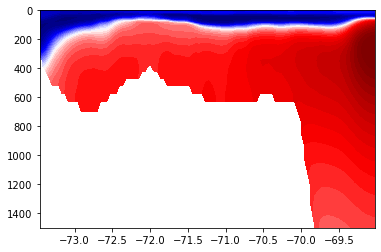

In [82]:
file_name = 'transect_23.nc'
transect_tmp = xr.open_dataset(file_path + file_name)
fig = plt.figure()
sc = plt.contourf(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect, levels=levels_temp, cmap='seismic', norm=norm_temp, extend='both')
#SC = plt.contourf(transect_tmp.xt_ocean, transect_tmp.st_ocean, transect_tmp.sigma1_transect)#, levels=levels_sigma1, cmap='binary')
plt.ylim(1500,0)

2 - Zonal transects

In [75]:
%%time
for ii in range(63,66):
    file_name = 'transect_'+str(ii)+'.nc'
    lat  = transect_lats[2*ii]
    lon1 = transect_lons[2*ii]
    lon2 = transect_lons[2*ii+1]
    # Temperature
    temp_transect = temp.sel(xt_ocean=slice(lon1,lon2)).sel(yt_ocean=lat, method='nearest') 
    temp_transect.attrs['latitude'] = lat
    temp_transect.attrs['units'] = 'C'
    # Potential density anomaly
    sigma1_transect = sigma1.sel(xt_ocean=slice(lon1,lon2)).sel(yt_ocean=lat, method='nearest') 
    sigma1_transect.attrs['longitude'] = lon
    sigma1_transect.attrs['units'] = 'kg/m3'
    # Saving transect
    ds = xr.Dataset({'temp_transect': temp_transect, 'sigma1_transect': sigma1_transect})
    ds.to_netcdf(file_path + file_name)

CPU times: user 37.1 s, sys: 1.35 s, total: 38.4 s
Wall time: 54.8 s


3 - WAP transects

In [58]:
# Load in a subset of the data (covering only the area of interest to reduce compute time).
temp_WAP   = temp.sel(yt_ocean=slice(-70.1, -59.9)).sel(xt_ocean=slice(-82.1, -47.9))
sigma1_WAP = sigma1.sel(yt_ocean=slice(-70.1, -59.9)).sel(xt_ocean=slice(-82.1, -47.9))
# No conversion of longitude range required, as we are in the 'normal' sector.

In [41]:
# Make use of the metpy.cross-section function to get transects that are neither zonal nor meridional
from metpy.interpolate import cross_section 

def get_transect(data, shelf_lat, shelf_lon, deep_lat, deep_lon, step_no=50):
    
    # Prep the data for the use of the metpy.cross-section function
    # Create dataset
    ds = xr.Dataset({"data": data, "lat": data.yt_ocean, "lon": data.xt_ocean, "ht": ht})
    # Rename coordinate names
    ds = ds.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    #ds['x'] = ds['x']+100
    # MetPy parsing
    data_parsed = ds.metpy.parse_cf('data', coordinates={'y': 'y', 'x': 'x'})
    # Finally, interpolate gridded data onto the section
    transect = cross_section(data_parsed, start=(shelf_lat, shelf_lon), end=(deep_lat, deep_lon), steps=step_no, interp_type='linear')
    
    return transect

Let's plot them directly (I ran into issues when trying to save the data).

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

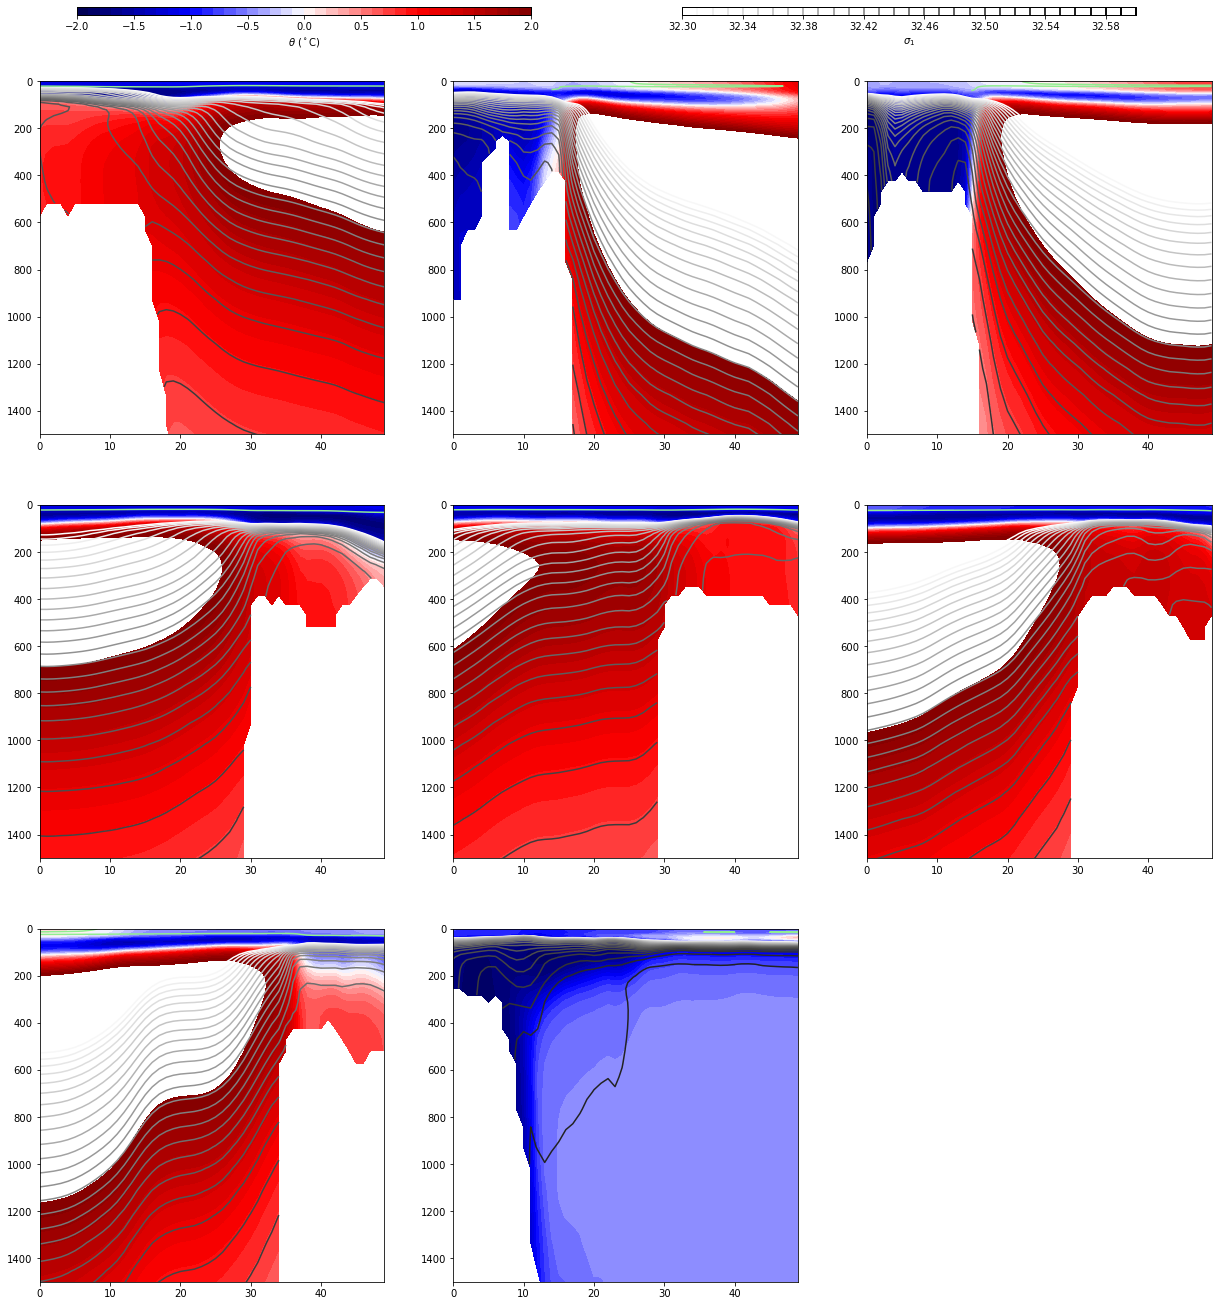

In [92]:
ft_size = 18
levels_temp   = np.arange(-2, 2.1, 0.1)
levels_sigma1 = np.arange(32.3,32.6,0.01)
norm_temp     = colors.Normalize(vmin=-2, vmax=2)

fig = plt.figure(figsize=(21, 23))

for ii in range(int(len(WAP_lats)/2)):

    shelf_lat = WAP_lats[2*ii]
    shelf_lon = WAP_lons[2*ii]
    deep_lat  = WAP_lats[2*ii+1]
    deep_lon  = WAP_lons[2*ii+1]
    
    transect_temp   = get_transect(temp_WAP, shelf_lat, shelf_lon, deep_lat, deep_lon)
    transect_sigma1 = get_transect(sigma1_WAP, shelf_lat, shelf_lon, deep_lat, deep_lon)
    
    plt.subplot(3,3,(ii+1))
    sc = plt.contourf(transect_temp.index, transect_temp.st_ocean, transect_temp, levels=levels_temp, cmap='seismic', norm=norm_temp)
    SC = plt.contour(transect_sigma1.index, transect_sigma1.st_ocean, transect_sigma1, levels=levels_sigma1, cmap='binary')
    plt.contour(transect_temp, levels=[0], colors='lightgreen')
    plt.ylim(1500,0)
    
    cax = fig.add_axes([0.15, 0.89, 0.3, 0.005])
    cbar=plt.colorbar(sc, cax=cax, orientation='horizontal', shrink=0.5)
    cbar.set_label(r'$\theta$ ($^\circ$C)')

    cax = fig.add_axes([0.55, 0.89, 0.3, 0.005])
    cbar=plt.colorbar(SC, cax=cax, orientation='horizontal', shrink=0.5)
    cbar.set_label(r'$\sigma_1$')
    
    plt.subplots_adjust(top=0.85)

In [89]:
for ii in range(1):#range(int(len(WAP_lats)/2)):
    
    shelf_lat = WAP_lats[2*ii]
    shelf_lon = WAP_lons[2*ii]
    deep_lat  = WAP_lats[2*ii+1]
    deep_lon  = WAP_lons[2*ii+1]
    
    transect_temp   = get_transect(temp_WAP, shelf_lat, shelf_lon, deep_lat, deep_lon)
    transect_sigma1 = get_transect(sigma1_WAP, shelf_lat, shelf_lon, deep_lat, deep_lon)
    
    # Saving transect
    #file_name = 'transect_'+WAP_names[ii]+'.nc'
    #ds = xr.Dataset({'temp_transect': transect_temp, 'sigma1_transect': transect_sigma1})
    # Rename coordinate names
    #ds = ds.rename({'x': 'xt_ocean', 'y': 'yt_ocean'})
    #ds.to_netcdf(file_path + file_name)
    

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [90]:
transect_temp

<xarray.DataArray 'data' (st_ocean: 75, index: 50)>
dask.array<dask_aware_interpnd, shape=(75, 50), dtype=float32, chunksize=(7, 50), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    geolon_t  (index) float64 -80.0 -80.04 -80.09 -80.13 ... -81.93 -81.96 -82.0
    geolat_t  (index) float64 -70.0 -69.96 -69.92 -69.88 ... -68.08 -68.04 -68.0
    crs       object Projection: latitude_longitude
    x         (index) float64 -80.0 -80.04 -80.09 -80.13 ... -81.93 -81.96 -82.0
    y         (index) float64 -70.0 -69.96 -69.92 -69.88 ... -68.08 -68.04 -68.0
  * index     (index) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

### **Monthly average**
The transects from which a monthly climatology is required were identified above. The information is stored in the `transects_monthly` array.

Import data

In [61]:
# Conservative temperature, convert to degree Celcius
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc") - 273.15
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# Practical salinity, convert later to absolute salinity
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

Monthly climatology

In [62]:
temp = temp.groupby('time.month').mean('time')
salt = salt.groupby('time.month').mean('time')

Calculate $\sigma_1$

In [ ]:
def get_sigma1():
    # Move longitude from ACCESS default to -180 - 180 (gsw library assumes either this or 0 - 360 format)
    temp['xt_ocean'] = temp['xt_ocean'] + 100
    salt['xt_ocean'] = salt['xt_ocean'] + 100
    pressure      = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
    salt_absolute = gsw.SA_from_SP(salt, pressure, salt.xt_ocean, salt.yt_ocean) # (move to lon range from -180 to 180)
    sigma1        = gsw.sigma1(salt_absolute, temp)
    # Move longitude range back to -280 to 80 (easier as all other data are in that format)
    temp['xt_ocean']   = temp['xt_ocean'] - 100
    sigma1['xt_ocean'] = sigma1['xt_ocean'] - 100
    return sigma1

In [65]:
sigma1 = get_sigma1()

In [71]:
%%time 
# Loop through transects in 'transects_monthly'
for ii in range(63):
    if ii in (transects_monthly):
        file_name = 'transect_'+str(ii)+'_monthly.nc'
        lon  = transect_lons[2*ii]
        lat1 = transect_lats[2*ii]
        lat2 = transect_lats[2*ii+1]
        # Temperature
        temp_transect = temp.sel(xt_ocean=lon, method='nearest').sel(yt_ocean=slice(lat1,lat2)) 
        temp_transect.attrs['longitude'] = lon
        temp_transect.attrs['units'] = 'C'
        # Potential density anomaly
        sigma1_transect = sigma1.sel(xt_ocean=lon, method='nearest').sel(yt_ocean=slice(lat1,lat2))
        sigma1_transect.attrs['longitude'] = lon
        sigma1_transect.attrs['units'] = 'kg/m3'
        # Saving transect
        ds = xr.Dataset({'temp_transect': temp_transect, 'sigma1_transect': sigma1_transect})
        ds.to_netcdf(file_path + file_name)

CPU times: user 5min 50s, sys: 15.7 s, total: 6min 5s
Wall time: 7min 32s


---

End of what you can skip, plotting section below.

### Plotting

In [114]:
ASF_classification = [1, 2, 2, 2, 2, 1, 1, 1, 1, 1, \
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 2, \
                      2, 2, 2, 3, 3, 3, 3, 3, 3, 3, \
                      3, 3, 3, 3, 3, 3, 1, 1, 1, 4, \
                      4, 2, 2, 2, 2, 1, 1, 2, 2, 2, \
                      2, 2, 2, 2, 2, 1, 1, 1, 1, 1, \
                      1, 1, 1, 2, 2, 2]

In [115]:
convinced_level    = [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, \
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
                      0, 0, 0, 1, 1, 1, 1, 1, 1, 1, \
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 0, \
                      0, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
                      1, 1, 1, 0, 1, 1]

**Annual average**

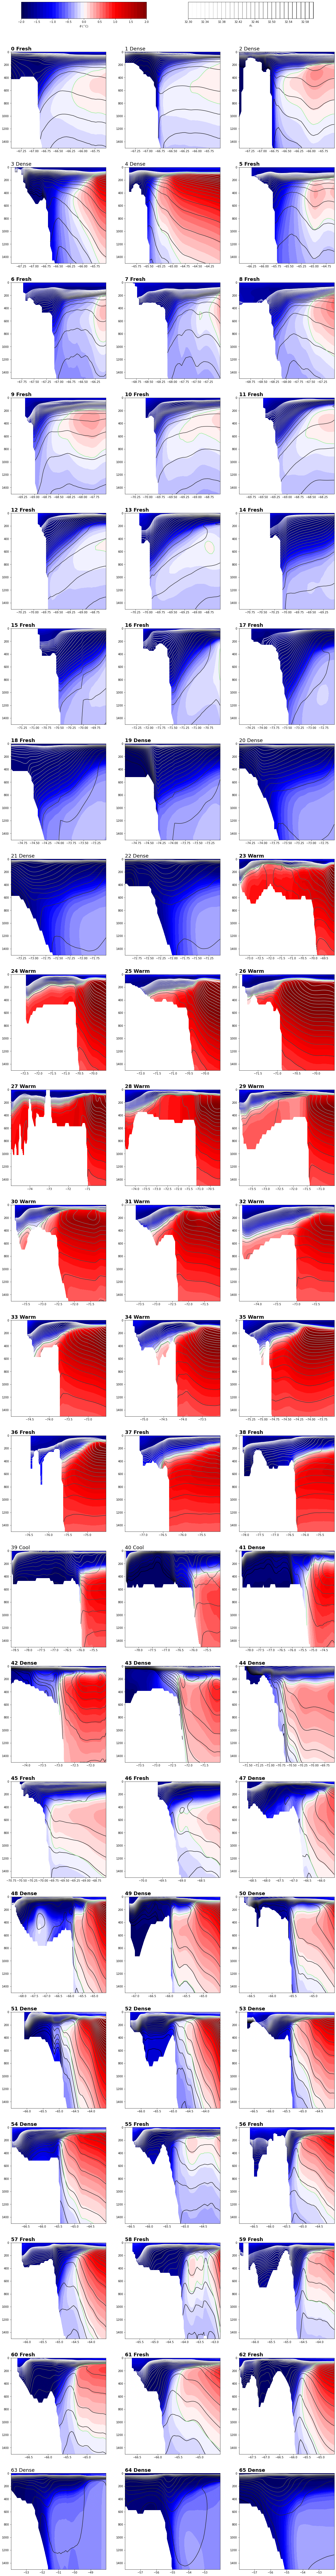

In [28]:
ft_size = 18
fig_path = '/g/data/x77/wgh581/Figures/'

file_path = '/g/data/x77/wgh581/Post_Process/Transects_ASF_classification/'
levels_temp   = np.arange(-2, 2.1, 0.1)
levels_sigma1 = np.arange(32.3,32.6,0.01)
norm_temp     = colors.Normalize(vmin=-2, vmax=2)

fig = plt.figure(figsize=(21, 168)) # 

for ii in range(66):
    
    plt.subplot(22, 3, ii+1)
    file_name = 'transect_'+str(ii)+'.nc'
    transect_tmp = xr.open_dataset(file_path + file_name)
    if ii < 63:
        sc = plt.contourf(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect, levels=levels_temp, cmap='seismic', norm=norm_temp, extend='both')
        SC = plt.contour(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.sigma1_transect, levels=levels_sigma1, cmap='binary')
        plt.contour(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect, levels=[0], colors='lightgreen')
    elif ii >= 63:
        sc = plt.contourf(transect_tmp.xt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect, levels=levels_temp, cmap='seismic', norm=norm_temp)
        SC = plt.contour(transect_tmp.xt_ocean, transect_tmp.st_ocean, transect_tmp.sigma1_transect, levels=levels_sigma1, cmap='binary')
        plt.contour(transect_tmp.xt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect, levels=[0], colors='lightgreen')
    plt.ylim(1500,0)
    if ASF_classification[ii] == 0:
        # Not classified
        title_name = ' '
    elif ASF_classification[ii] == 1:
        title_name = 'Fresh'
    elif ASF_classification[ii] == 2:
        title_name = 'Dense'
    elif ASF_classification[ii] == 3:
        title_name = 'Warm'
    elif ASF_classification[ii] == 4:
        title_name = 'Cool'
    if convinced_level[ii] == 0:
        plt.title(str(ii) + ' ' + title_name, loc='left', fontsize=ft_size)
    elif convinced_level[ii] == 1:
        plt.title(str(ii) + ' ' + title_name, loc='left', fontsize=ft_size, fontweight='bold')
cax = fig.add_axes([0.15, 0.89, 0.3, 0.005])
cbar=plt.colorbar(sc, cax=cax, orientation='horizontal', shrink=0.5)
cbar.set_label(r'$\theta$ ($^\circ$C)')

cax = fig.add_axes([0.55, 0.89, 0.3, 0.005])
cbar=plt.colorbar(SC, cax=cax, orientation='horizontal', shrink=0.5)
cbar.set_label(r'$\sigma_1$')

**Monthly average**

In [75]:
transects_monthly

array([ 1,  2,  3,  4, 19, 20, 21, 22, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54])

In [118]:
# Plot each month and count the months that classify as dense, then add them to the belo 'dense_months' array.
dense_months = [2, 5, 6, 4, 10, 0, 3, 0, 0, 4, 3, 8, 7, 12, 3, 3, 0, 12, 8, 12, 12, 12, 12, 12, 12]
for ii in range(len(transects_monthly)):
    if dense_months[ii] > 0:
        print(transects_monthly[ii])

1
2
3
4
19
21
39
40
41
42
43
44
45
47
48
49
50
51
52
53
54


In [91]:
ft_size = 18
fig_path = '/g/data/x77/wgh581/Figures/'

file_path = '/g/data/x77/wgh581/Post_Process/Transects_ASF_classification/'
levels_temp   = np.arange(-2, 2.1, 0.1)
levels_sigma1 = np.arange(32.3,32.6,0.01)
norm_temp     = colors.Normalize(vmin=-2, vmax=2)

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def plot_monthly_average(ii):
    
    fig = plt.figure(figsize=(21, 30)) 
    file_name = 'transect_'+str(ii)+'_monthly.nc'
    transect_tmp = xr.open_dataset(file_path + file_name)
    
    for tt in range(len(month)):
        plt.subplot(4, 3, tt+1)
        if tt == 0:
            plt.title('Transect %i: '%ii + month[tt], fontsize=ft_size, loc='left')
        else: 
            plt.title(month[tt], fontsize=ft_size, loc='left')
        sc = plt.contourf(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect[tt,:,:], levels=levels_temp, cmap='seismic', norm=norm_temp, extend='both')
        SC = plt.contour(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.sigma1_transect[tt,:,:], levels=levels_sigma1, cmap='binary')
        plt.contour(transect_tmp.yt_ocean, transect_tmp.st_ocean, transect_tmp.temp_transect[tt,:,:], levels=[0], colors='lightgreen')

        plt.ylim(1500,0)

    cax = fig.add_axes([0.15, 0.89, 0.3, 0.005])
    cbar=plt.colorbar(sc, cax=cax, orientation='horizontal', shrink=0.5)
    cbar.set_label(r'$\theta$ ($^\circ$C)')

    cax = fig.add_axes([0.55, 0.89, 0.3, 0.005])
    cbar=plt.colorbar(SC, cax=cax, orientation='horizontal', shrink=0.5)
    cbar.set_label(r'$\sigma_1$')
    
    plt.subplots_adjust(top=0.85)

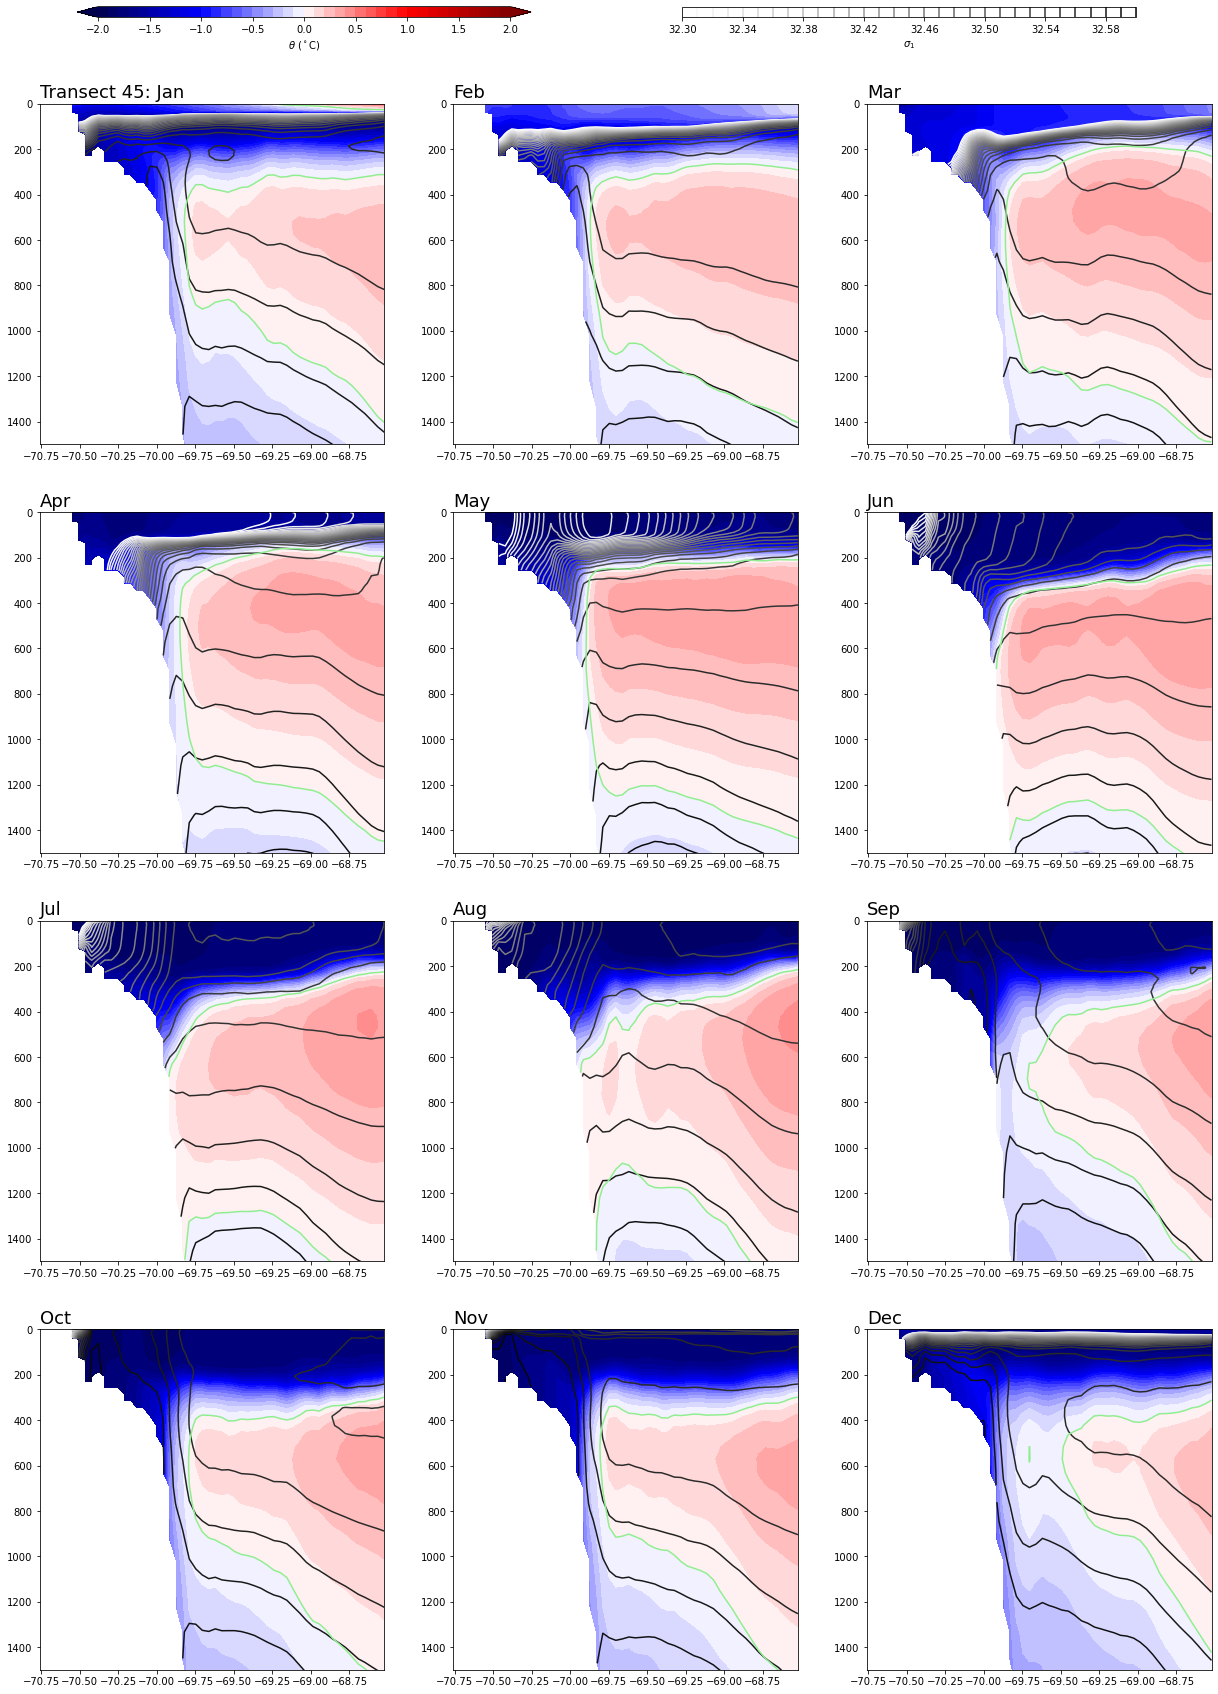

In [122]:
plot_monthly_average(transects_monthly[15])

### Update the map by colour-coding the transects according to the ASF classification

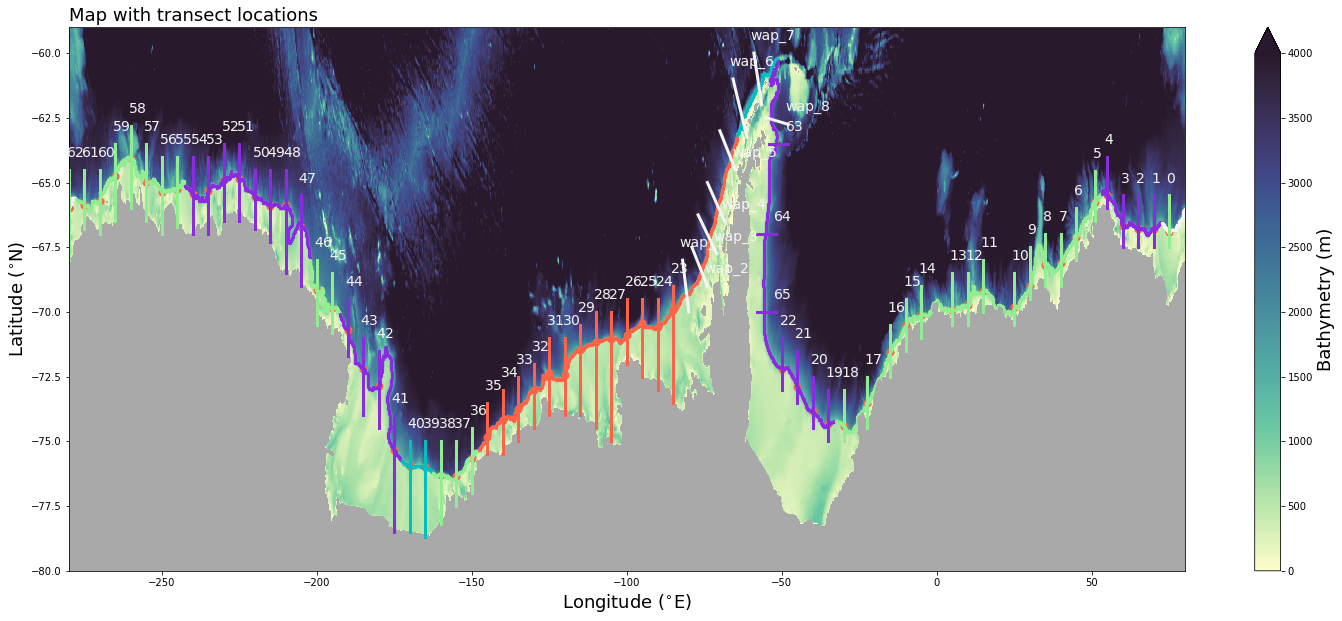

In [193]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1,1,1)
plt.title('Map with transect locations', fontsize=ft_size, loc='left')
plt.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
sc = plt.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, cmap=cm.cm.deep, vmin=0, vmax=4000)
plt.scatter(lon_along_contour, lat_along_contour, c='whitesmoke', s=5)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -59)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
cbar = plt.colorbar(sc, extend='max')
cbar.set_label('Bathymetry (m)', fontsize=ft_size)
# Add transects
for ii in range(int(len(transect_lons)/2)):
    if ASF_classification[ii] == 0:
        transect_colour = 'whitesmoke'
    elif ASF_classification[ii] == 1:
        transect_colour = 'lightgreen'
    elif ASF_classification[ii] == 2:
        transect_colour = 'blueviolet'
    elif ASF_classification[ii] == 3:
        transect_colour = 'tomato'
    elif ASF_classification[ii] == 4:
        transect_colour = 'c'
    plt.plot(transect_lons[2*ii:2*ii+2], transect_lats[2*ii:2*ii+2], color=transect_colour, linewidth=3)
    plt.text(transect_lons[2*ii+1]-1, transect_lats[2*ii+1]+0.5, '$\mathsf{'+str(ii)+'}$', fontsize=ft_size-4, color='whitesmoke')
for ii in range(len(WAP_names)):
    plt.plot(WAP_lons[2*ii:2*ii+2], WAP_lats[2*ii:2*ii+2], color='whitesmoke', linewidth=3)
    plt.text(WAP_lons[2*ii+1]-1, WAP_lats[2*ii+1]+0.5, WAP_names[ii], fontsize=ft_size-4, color='whitesmoke')

for ii in range(len(ind)):
    plt.scatter(lon_along_contour[int(ind[ii])], lat_along_contour[int(ind[ii])], c='tomato', s=50)

for ii in range(num_points):
    if ASF_regimes[ii] == 0:
        transect_colour = 'whitesmoke'
    elif ASF_regimes[ii] == 1:
        transect_colour = 'lightgreen'
    elif ASF_regimes[ii] == 2:
        transect_colour = 'blueviolet'
    elif ASF_regimes[ii] == 3:
        transect_colour = 'tomato'
    elif ASF_regimes[ii] == 4:
        transect_colour = 'c'
    plt.scatter(lon_along_contour[ii], lat_along_contour[ii], c=transect_colour, s=5)

plt.subplots_adjust(hspace=0.3);

### Now make a vector for the 1 km isobath

Decide which array to rotate and rotate before selecting the indices!

In [181]:
# We have the classification for the transects, now I want to make a vector with length of extracted the 1 km contour. This array I can save and use on the ASC plots.

# Find index on contour that is closest to each transect
transect_lons_reverse = transect_lons[::2][::-1]
transect_lats_reverse = transect_lats[::2][::-1]

ind = np.zeros((np.size(transect_lons_reverse)))

for ii in range(len(ind)-3): # Skip the first three entries
    ind[ii+3] = np.argmin((lon_along_contour - transect_lons_reverse[ii+3])**2)
    
"""
# The first three (Weddell Sea)
lat_along_contour_reversed_starting_from_transect22 = lat_along_contour[:int(ind[22])]
lat_along_contour_reversed_starting_from_transect22 = lat_along_contour_reversed_starting_from_transect22[::-1]
for ii in range(0, 2):
    ind_tmp = np.argmin( (lat_along_contour_reversed_starting_from_transect22 - transect_lats_reverse[ii])**2 )
    ind[ii] = ind[22] - ind_tmp
""" ;
# Note that the contour array is from west to east, but the ASF_classification is from east to west.

In [182]:
ASF_regimes = np.zeros((num_points))
for ii in range(len(ind)):
    if ii == 3:
        ASF_regimes[:int(ind[ii])] = ASF_classification[::-1][ii]
    elif ii > 3:# and ii < 40:
        min_ind = int( (ind[ii]   - ind[ii-1]) / 2)
        min_ind = int( ind[ii] - min_ind ) -1
        max_ind = int( (ind[ii+1] - ind[ii])   / 2)
        max_ind = int( ind[ii] + max_ind )
        ASF_regimes[min_ind:max_ind] = ASF_classification[::-1][ii]

IndexError: index 66 is out of bounds for axis 0 with size 66

**Fix a few things by hand**

1 - Add the cold regime at the tip of WAP: (from WAP transects)

In [189]:
# For my 1 km selection approach (using plt.contour):
ASF_regimes[2530:2530+152] = 4
# For Adele's 1 km selection approach:
#ASF_regimes[3350:3350+190] = 4

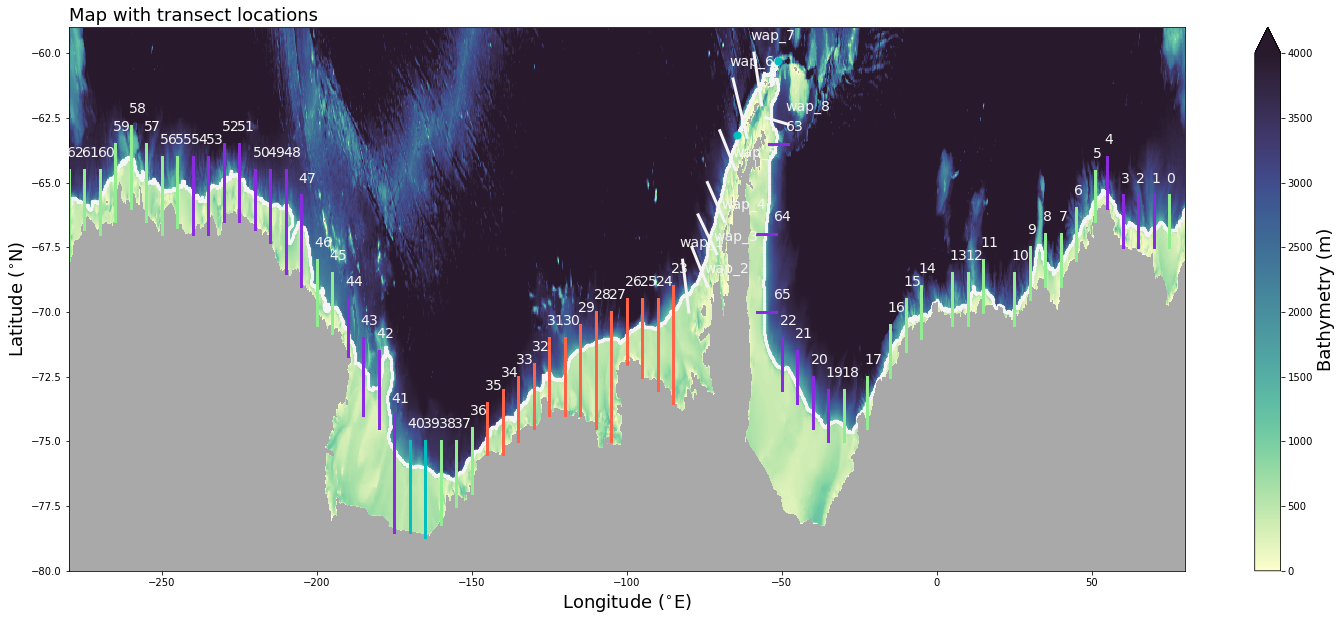

In [188]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1,1,1)
plt.title('Map with transect locations', fontsize=ft_size, loc='left')
plt.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
sc = plt.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, cmap=cm.cm.deep, vmin=0, vmax=4000)
plt.scatter(lon_along_contour, lat_along_contour, c='whitesmoke', s=5)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -59)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
cbar = plt.colorbar(sc, extend='max')
cbar.set_label('Bathymetry (m)', fontsize=ft_size)
# Add transects
for ii in range(int(len(transect_lons)/2)):
    if ASF_classification[ii] == 0:
        transect_colour = 'whitesmoke'
    elif ASF_classification[ii] == 1:
        transect_colour = 'lightgreen'
    elif ASF_classification[ii] == 2:
        transect_colour = 'blueviolet'
    elif ASF_classification[ii] == 3:
        transect_colour = 'tomato'
    elif ASF_classification[ii] == 4:
        transect_colour = 'c'
    plt.plot(transect_lons[2*ii:2*ii+2], transect_lats[2*ii:2*ii+2], color=transect_colour, linewidth=3)
    plt.text(transect_lons[2*ii+1]-1, transect_lats[2*ii+1]+0.5, '$\mathsf{'+str(ii)+'}$', fontsize=ft_size-4, color='whitesmoke')
for ii in range(len(WAP_names)):
    plt.plot(WAP_lons[2*ii:2*ii+2], WAP_lats[2*ii:2*ii+2], color='whitesmoke', linewidth=3)
    plt.text(WAP_lons[2*ii+1]-1, WAP_lats[2*ii+1]+0.5, WAP_names[ii], fontsize=ft_size-4, color='whitesmoke')

plt.scatter(lon_along_contour[2530], lat_along_contour[2530], color='c', s=50)
plt.scatter(lon_along_contour[2530+152], lat_along_contour[2530+152], color='c', s=50)

plt.subplots_adjust(hspace=0.3);

In [184]:
#print(lon_along_contour[2520])
#print(lat_along_contour[2520])

-65.00000000000543
-63.517907571876506


In [187]:
#test = ASF_regimes[2530:]
#testind = np.argmin((test-2)**2)
#testind

152

2 - Change the values at the end to fresh

In [194]:
# This is an artifact of the way I calculate the regimes.
ASF_regimes[ASF_regimes == 0] = 1

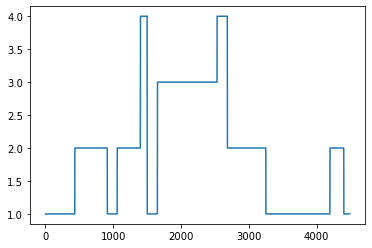

In [195]:
fig = plt.figure()
plt.plot(ASF_regimes);

### Save the output

In [196]:
# Save the ASF_regimes data:
import os
outfile = os.path.join(file_path, 'ASF_regimes_01deg_jra55v13_ryf9091_plt_approach.npz')
np.savez(outfile, ASF_regimes=ASF_regimes)

Note:
- could do ASC classification also just at the points of the transects (same resolution for comparison), but then I loose the high res that I have from my current 